<a href="https://colab.research.google.com/github/GrinddMaster/My_Grind/blob/main/RunTimeGpuHopefully.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

andrewmvd_retinal_disease_classification_path = kagglehub.dataset_download('andrewmvd/retinal-disease-classification')
grindmaster79_retinal_lables_path = kagglehub.dataset_download('grindmaster79/retinal-lables')

print('Data source import complete.')


In [ ]:
"""
    _    _ _   _   _                    _
   / \  | (_) | | | |_   _ ___ ___  ___(_)_ __
  / _ \ | | | | |_| | | | / __/ __|/ _ \ | '_ \
 / ___ \| | | |  _  | |_| \__ \__ \  __/ | | | |
/_/   \_\_|_| |_| |_|\__,_|___/___/\___|_|_| |_|

 ____   ___  _  ___   ___  _ __________
|___ \ / _ \/ |/ _ \ / _ \/ |___ /___ /
  __) | | | | | | | | (_) | | |_ \ |_ \
 / __/| |_| | | |_| |\__, | |___) |__) |
|_____|\___/|_|\___/   /_/|_|____/____/
"""

"\n    _    _ _   _   _                    _       \n   / \\  | (_) | | | |_   _ ___ ___  ___(_)_ __  \n  / _ \\ | | | | |_| | | | / __/ __|/ _ \\ | '_ \\ \n / ___ \\| | | |  _  | |_| \\__ \\__ \\  __/ | | | |\n/_/   \\_\\_|_| |_| |_|\\__,_|___/___/\\___|_|_| |_|\n\n ____   ___  _  ___   ___  _ __________ \n|___ \\ / _ \\/ |/ _ \\ / _ \\/ |___ /___ / \n  __) | | | | | | | | (_) | | |_ \\ |_ \\ \n / __/| |_| | | |_| |\\__, | |___) |__) |\n|_____|\\___/|_|\\___/   /_/|_|____/____/                                                                                         \n"

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import cv2
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import threading
from concurrent.futures import ThreadPoolExecutor
import plotly.graph_objects as go
from IPython.display import clear_output
clear_output(wait=True)



   ID  Disease_Risk  DR  ARMD  MH  DN  MYA  BRVO  TSLN  ERM  ...  CME  PTCR  \
0   1             1   1     0   0   0    0     0     1    0  ...    0     0   
1   2             1   0     0   0   0    0     0     0    0  ...    0     0   
2   3             1   0     0   0   0    0     0     0    0  ...    0     0   
3   4             1   0     0   0   0    0     0     0    0  ...    0     0   
4   5             1   0     0   0   0    0     0     0    0  ...    0     0   

   CF  VH  MCA  VS  BRAO  PLQ  HPED  CL  
0   0   0    0   0     0    0     0   0  
1   0   0    0   0     0    0     0   0  
2   0   0    0   0     0    0     0   0  
3   0   0    0   0     0    0     0   0  
4   0   0    0   0     0    0     0   0  

[5 rows x 47 columns]
(3200, 47)


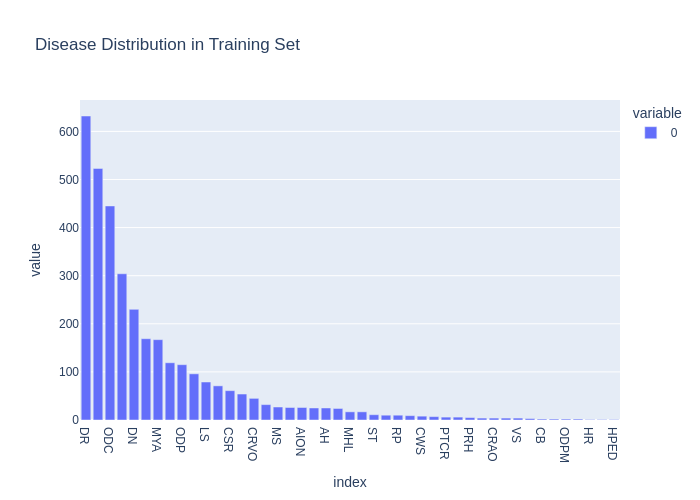

1


In [ ]:
data = pd.read_csv('/kaggle/input/retinal-lables/Labels.csv')
Eval_labels_path = pd.read_csv('/kaggle/input/retinal-disease-classification/Evaluation_Set/Evaluation_Set/RFMiD_Validation_Labels.csv')
Test_labels_path = pd.read_csv('/kaggle/input/retinal-disease-classification/Test_Set/Test_Set/RFMiD_Testing_Labels.csv')
Train_labels_path = pd.read_csv('/kaggle/input/retinal-disease-classification/Training_Set/Training_Set/RFMiD_Training_Labels.csv')
print(data.head())

Eval_set_path = '/kaggle/input/retinal-disease-classification/Evaluation_Set/Evaluation_Set/Validation'
Test_set_path = '/kaggle/input/retinal-disease-classification/Test_Set/Test_Set/Test'
Train_set_path = '/kaggle/input/retinal-disease-classification/Training_Set/Training_Set/Training'

print(data.shape)
disease_counts = data.iloc[:, 2:].sum().sort_values(ascending=False)
fig = px.bar(disease_counts, title="Disease Distribution in Training Set")
fig.show(renderer = "png")

count = 1
print(count)
#pip install -U kaleido
#Restart kernel GoTo -> Run -> Restart & ClearSession

In [ ]:

def load_Elabels(img_id):
    labels = []
    for id in img_id['ID']:
        matching_row = Eval_labels_path[Eval_labels_path['ID']==id]
        if not matching_row.empty:
            row = Eval_labels_path[Eval_labels_path['ID'] == id].iloc[0]
            labels.append(row['Disease_Risk'])
        else:
            print(f'{id} isnt found')
    return np.array(labels)
def load_Telabels(img_id):
    labels = []
    for id in img_id['ID']:
        matching_row = Test_labels_path[Test_labels_path['ID']==id]
        if not matching_row.empty:
            row = Eval_labels_path[Eval_labels_path['ID'] == id].iloc[0]
            labels.append(row['Disease_Risk'])
        else:
            print(f'{id} isnt found')
    return np.array(labels)
def load_Trlabels(img_id):
    labels = []
    for id in img_id['ID']:
        matching_row = Train_labels_path[Train_labels_path['ID']==id]
        if not matching_row.empty:
            row = Train_labels_path[Train_labels_path['ID'] == id].iloc[0]
            labels.append(row['Disease_Risk'])
        else:
            print(f'{id} isnt found')
    return np.array(labels)
print('Hello world')
Eval_labels = load_Elabels(Eval_labels_path)
print(Eval_labels.shape)
Test_labels = load_Telabels(Test_labels_path)
print(Test_labels.shape)
Train_labels = load_Trlabels(Train_labels_path)
print(Train_labels.shape)

Ytrain = np.concatenate((Eval_labels,Test_labels,Train_labels))
print(Ytrain.shape)
#Now all the images and Lables are in Xtrain

Hello world
(640,)
(640,)
(1920,)
(3200,)


In [ ]:
testgen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode='nearest'
)

In [ ]:
def load_images(img_id,img_path):#this function returns all the images and lables in one big array
    images = []
    for id in img_id['ID']:
        full_img_path = os.path.join(img_path, f"{id}.png")
        if os.path.exists(full_img_path):
            img = cv2.imread(full_img_path)
            if img is not None:
                img = cv2.resize(img,(246,246))
                images.append(img)
    return np.array(images)

Eval_images = load_images(Eval_labels_path,Eval_set_path)
Test_images = load_images(Test_labels_path,Test_set_path)
Train_images = load_images(Train_labels_path,Train_set_path)
Xtrain = np.concatenate((Eval_images,Test_images,Train_images))
print(Xtrain.shape)
#Now all the iamges and Lables are in Xtrain

(3200, 246, 246, 3)


In [ ]:
Xtrain = Xtrain/255.0 #Normalize the data.

In [ ]:
augmented_test = testgen.flow(Test_images,Test_labels,shuffle=True)

In [ ]:
def Model_Training():
  model = Sequential([
      Conv2D(32, (3, 3), activation='relu',input_shape=(246,246,3)),
      MaxPooling2D((2, 2)),
      Conv2D(74, (3, 3), activation='relu'),
      MaxPooling2D((2, 2)),
      Conv2D(84, (3, 3), activation='relu'),
      MaxPooling2D((2, 2)),
      Conv2D(94, (3, 3), activation='relu'),
      MaxPooling2D((2, 2)),
      Conv2D(128, (3, 3), activation='relu'),
      MaxPooling2D((2, 2)),
      Flatten(),
      Dense(46, activation='relu'),
      Dense(86, activation='relu'),
      Dense(96, activation='relu'),
      Dense(56, activation='relu'),
      Dense(50, activation='relu'),
      Dense(12, activation='relu'),
      Dense(40, activation='relu'),
      Dropout(0.5),
      Dense(1, activation='sigmoid')
  ])
  model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
model = Model_Training()

kf = KFold(n_splits=5)
fold_no = 1
for train_index, val_index in kf.split(Xtrain):
    Xtrain_fold,Xval_fold = Xtrain[train_index],Xtrain[val_index]
    Ytrain_fold,Yval_fold = Ytrain[train_index],Ytrain[val_index]
    print(f'Training fold {fold_no}...')

    history=model.fit(Xtrain_fold, Ytrain_fold, epochs=50, validation_data=(Xval_fold, Yval_fold))

    fold_no += 1


Training fold 1...
Epoch 1/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 15s 95ms/step - accuracy: 0.7619 - loss: 0.5835 - val_accuracy: 0.7906 - val_loss: 0.4859
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.7785 - loss: 0.5123 - val_accuracy: 0.7906 - val_loss: 0.5390
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.7794 - loss: 0.5029 - val_accuracy: 0.7906 - val_loss: 0.5387
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.7868 - loss: 0.5020 - val_accuracy: 0.7906 - val_loss: 0.4522
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.7997 - loss: 0.4451 - val_accuracy: 0.8156 - val_loss: 0.4551
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.8051 - loss: 0.4743 - val_accuracy: 0.8156 - val_loss: 0.4214
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.8192 - loss: 0.4386 - val_accuracy: 0.8172 - val_loss: 0.4381
Epoch 8/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.8275 - loss: 0.4303 - val_

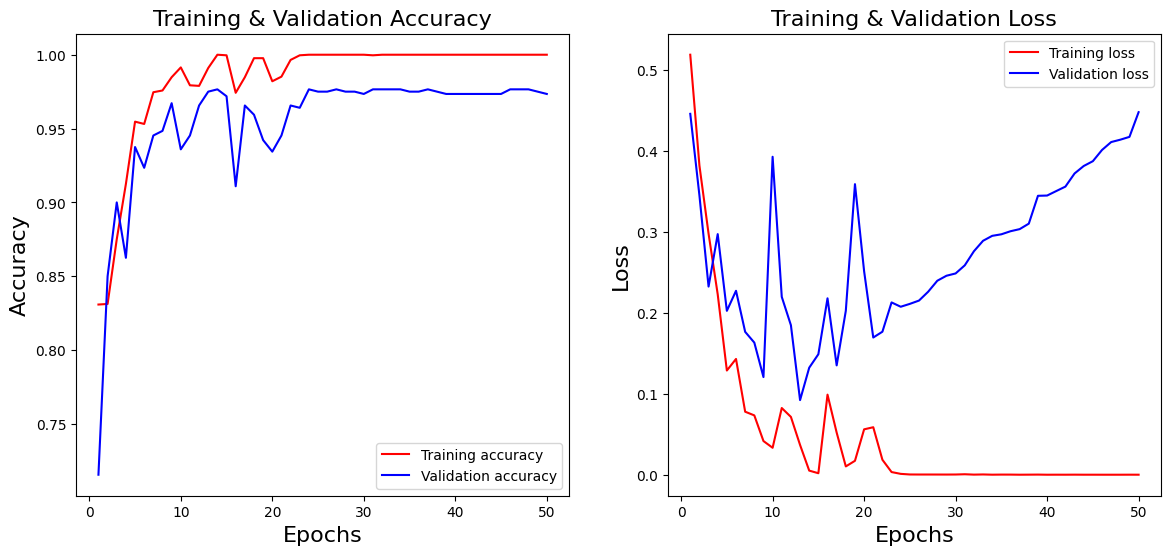

In [ ]:

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
#
# Plot the model accuracy vs Epochs
#
ax[0].plot(epochs, accuracy, 'r', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()
#
# Plot the loss vs Epochs
#
ax[1].plot(epochs, loss_values, 'r', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'b', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

In [ ]:

y_pred = (model.predict(augmented_test) > 0.5).astype("int32")

print("Accuracy:", accuracy_score(Test_labels, y_pred))
print("Classification Report:")
print(classification_report(Test_labels, y_pred))

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 338ms/step
Accuracy: 0.7625
Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.09      0.14       134
           1       0.80      0.94      0.86       506

    accuracy                           0.76       640
   macro avg       0.54      0.52      0.50       640
weighted avg       0.69      0.76      0.71       640



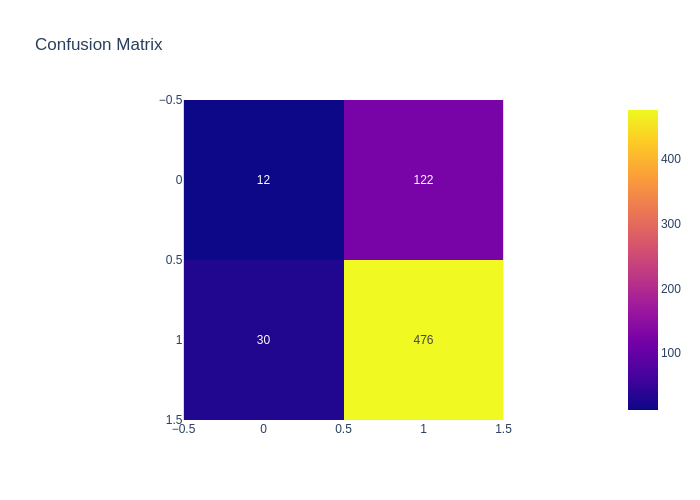

In [ ]:
cm = confusion_matrix(Test_labels, y_pred)
fig = px.imshow(cm, text_auto=True, title="Confusion Matrix")
fig.show(renderer = "png")

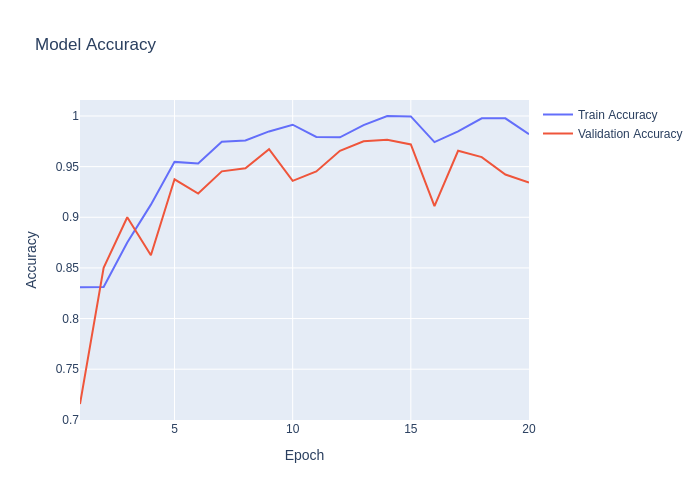

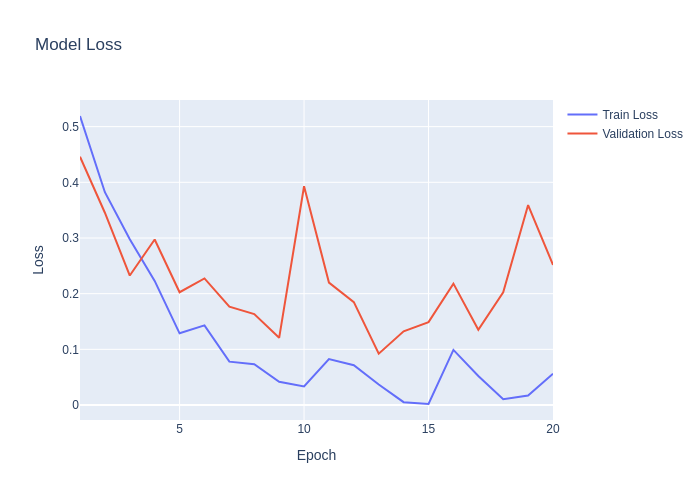

In [ ]:
# Plot training history
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1, 21)), y=history.history['accuracy'], mode='lines', name='Train Accuracy'))
fig.add_trace(go.Scatter(x=list(range(1, 21)), y=history.history['val_accuracy'], mode='lines', name='Validation Accuracy'))
fig.update_layout(title='Model Accuracy', xaxis_title='Epoch', yaxis_title='Accuracy')
fig.show(renderer="png")

fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1, 21)), y=history.history['loss'], mode='lines', name='Train Loss'))
fig.add_trace(go.Scatter(x=list(range(1, 21)), y=history.history['val_loss'], mode='lines', name='Validation Loss'))
fig.update_layout(title='Model Loss', xaxis_title='Epoch', yaxis_title='Loss')
fig.show(renderer="png")

In [ ]:
model.save('/kaggle/working/retinal_disease_classification_model.h5')